Préparation et modélisation des données

In [2]:
# Import des bibliothèque
from sklearn import ensemble
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
# Lecture du fichier 'churn.csv'
churn_df = pd.read_csv('churn.csv')

In [4]:
churn_df.info()
churn_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Les colonnes ‘state’, ‘area code’ et ‘phone' sont des données personnelles qui à priori n’influe pas sur le fait de se désabonner d’un contrat ou non. Il est donc possible, voire recommandé de les supprimer. 
Les colonnes Int'l Plan' et ‘VMail Plan’ représentent la souscription à des option, et il est préférable de remplacer ces features par des variables indicatrices, car les forêts aléatoires sur scikit-learn ne gèrent pas les variables qualitatives. 


In [5]:
# Création variable target
target = churn_df['Churn']

# Transformation de variable en variable indicatrice

churn_df = churn_df.join(pd.get_dummies(churn_df['Int\'l Plan'], prefix='International'))
churn_df = churn_df.join(pd.get_dummies(churn_df['VMail Plan'], prefix='voicemail'))


to_drop = ['Int\'l Plan', 'VMail Plan', 'State', 'Area Code', 'Phone', 'Churn']
data = churn_df.drop(to_drop, axis=1)

In [6]:
# Séparation jeu de donnée
# Random_state=12 -> Reproductibilité du choix aléatoire

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=12)

# Apprentissage des données
Les algorithmes de forêts aléatoires sont un cas particulier du Bagging appliqué aux arbres de décision (CART). 
En plus du principe de Bagging, les forêts aléatoires ajoutent de l’aléa au niveau des variables. Pour chaque arbre on sélectionne un sous-échantillon par Bootstrap d’individus et à chaque étape, la construction d’un nœud de l’arbre se fait sur un sous-ensemble de variables tirées aléatoirement. 
Le principe de fonctionnement des forêts aléatoires est simple : de nombreux petits arbres de classification sont produits sur une fraction aléatoire de données. 
Random Forest ensuite voter ces arbres de classification peu corrélés afin de déduire l’ordre et l’importance des variables explicatives.


In [7]:
# Création classificateur et construction modèle sur données entraînement
clf = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321)
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=321)

In [8]:
# Prédiction stocker y_pred
y_pred = clf.predict(X_test)

#Affichage matrice confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,False,True
Classe réelle,,
False,573,1
True,17,76


La matrice de confusion nous montre que le modèle performe dans la prédiction des clients qui ne se désabonnent pas. En revanche, celui-ci éprouve des difficultés à classer des clients qui se sont bel et bien désabonnés.

Le modèle n'a donc pas de haute performance au premier abord pour trouver les "churners" potentiels, m^me si le taux de bonnes prédictions du modèle reste très bon grâce à la petite proportion de 'churner' dans les données.


In [9]:
# Calcule tx de bonnes prédictions
clf.score(X_test, y_test)

0.9730134932533733

In [10]:
# Calcul proba pour X_test d'appartenir à chacune des deux classes. 
y_probas = clf.predict_proba(X_test)

Une manière différente d’évaluer la performance de notre modèle est la création d’une courbe lift cumulée (ou courbe de gain).

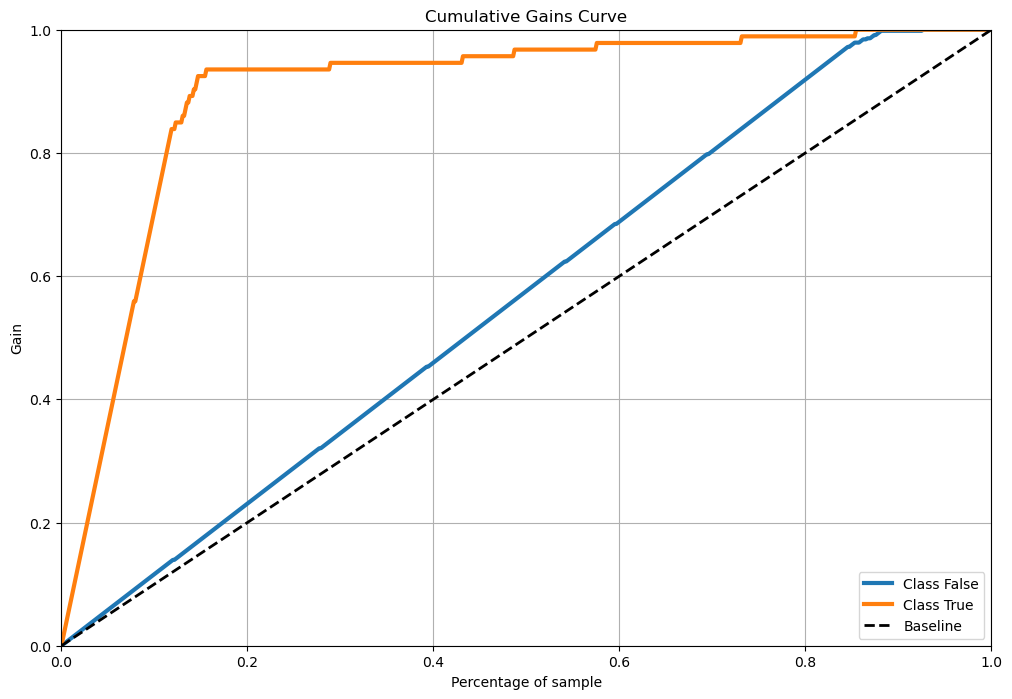

In [11]:

import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(12,8))
plt.show()


L’axe horizontal représente les individus de l’échantillon test , l’axe vertical les churner.
La courbe montre qu’en ciblant, par exemple, uniquement les 20% des clients ayant obtenu le meilleur score par le modèle (c’est-à-dire les 20% des clients avec la plus forte probabilité de se désabonner), plus de 90% des churner en devenir seront ainsi atteints alors qu’en sélectionnant 20% des clients de manière aléatoire, seuls 20% des churner seront atteints. 
Cette méthode permet de cibler plus facilement, et à moindre coût le s clients / consommateurs susceptibles de stopper leur abonnement. 
La courbe lift cumulée est donc un outil très utilise pour des opérations de ciblage, pour réduire les coûts d’une opération et maximiser le rendement. 
